In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np
from tqdm import tqdm
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class ViolenceDataset(Dataset):
    def __init__(self, root_dir, transform=None, frames=16, size=224):
        self.samples = []
        self.transform = transform
        self.frames = frames
        self.size = size

        for label, folder in enumerate(['NonViolence', 'Violence']):
            class_dir = os.path.join(root_dir, folder)
            for file in os.listdir(class_dir):
                if file.endswith('.mp4'):
                    self.samples.append((os.path.join(class_dir, file), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        cap = cv2.VideoCapture(path)
        frames = []

        while len(frames) < self.frames:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (self.size, self.size))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0
            frames.append(frame)

        cap.release()

        if len(frames) < self.frames:
            padding = [torch.zeros_like(frames[0]) for _ in range(self.frames - len(frames))]
            frames += padding
        video = torch.stack(frames[:self.frames]).permute(1, 0, 2, 3)

        if self.transform:
            video = self.transform(video)

        return video, label

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohamedmustafa/real-life-violence-situations-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'real-life-violence-situations-dataset' dataset.
Path to dataset files: /kaggle/input/real-life-violence-situations-dataset


In [6]:
import os
import glob
dataset_path = "/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset"

violence_videos = glob.glob(os.path.join(dataset_path, "Violence", "*.mp4"))
non_violence_videos = glob.glob(os.path.join(dataset_path, "NonViolence", "*.mp4"))

print("Violence:", len(violence_videos))
print("NonViolence:", len(non_violence_videos))
print("Всего:", len(violence_videos) + len(non_violence_videos))


Violence: 1000
NonViolence: 951
Всего: 1951


In [8]:
class ResizeAndCrop:
    def __init__(self, size):
        self.size = size

    def __call__(self, video):
        T, C, H, W = video.shape
        h_start = random.randint(0, H - self.size)
        w_start = random.randint(0, W - self.size)
        return video[:, :, h_start:h_start+self.size, w_start:w_start+self.size]

transform = transforms.Compose([
    ResizeAndCrop(224)
])

dataset = ViolenceDataset(dataset_path, transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

In [9]:
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_set, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


In [28]:
class CNNGRU(nn.Module):
    def __init__(self, num_classes=2, cnn_out_features=512, rnn_hidden_size=256, num_layers=2):
        super(CNNGRU, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, cnn_out_features)
        )
        self.rnn = nn.GRU(cnn_out_features, rnn_hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(rnn_hidden_size, num_classes)

    def forward(self, x):
        # x shape: [batch_size, channels, frames, height, width]
        batch_size, channels, frames, height, width = x.size()

        # ЗАМЕНА: .view() на .reshape() или добавляем .contiguous()
        # reshape сам позаботится о памяти
        c_in = x.transpose(1, 2).reshape(batch_size * frames, channels, height, width)

        c_out = self.cnn(c_in)

        # Здесь тоже лучше использовать reshape для надежности
        r_in = c_out.reshape(batch_size, frames, -1)

        r_out, h_n = self.rnn(r_in)
        out = self.fc(r_out[:, -1, :])
        return out

model = CNNGRU().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()


/tmp/ipython-input-3214571096.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [20]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for videos, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        videos, labels = videos.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(videos)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * videos.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for videos, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            videos, labels = videos.to(device), labels.to(device)
            with autocast():
                outputs = model(videos)
                loss = criterion(outputs, labels)
            val_loss += loss.item() * videos.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(val_acc)

    if val_acc*100 >= 84.0:
      from safetensors.torch import save_file

      # 1. Получаем state_dict
      state_dict = model.state_dict()

      # 2. Фикс для shared tensors: делаем копии, чтобы они не делили память
      # .contiguous() и .clone() гарантируют, что тензор занимает свой кусок памяти
      clean_state_dict = {k: v.clone().contiguous() for k, v in state_dict.items()}

      # 3. Сохраняем через save_file (это надежнее для отдельных файлов)
      save_file(clean_state_dict, f"model_acc_{val_acc:.2f}.safetensors")
      print(f"--> Target accuracy reached! Model saved as model_acc_{val_acc:.2f}.safetensors")


    print(f"[Epoch {epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% || "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")


Epoch 1/15 - Training:   0%|          | 0/171 [00:00<?, ?it/s]/tmp/ipython-input-250102371.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/15 - Training:  13%|█▎        | 22/171 [00:09<00:49,  2.99it/s]/tmp/ipython-input-250102371.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/15 - Validation:   0%|          | 0/37 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.che

0.7191780821917808
[Epoch 1/15] Train Loss: 0.6632 | Train Acc: 57.95% || Val Loss: 0.5356 | Val Acc: 71.92%


Epoch 2/15 - Validation: 100%|██████████| 37/37 [00:15<00:00,  2.32it/s]


0.8047945205479452
[Epoch 2/15] Train Loss: 0.4424 | Train Acc: 78.53% || Val Loss: 0.3838 | Val Acc: 80.48%


Epoch 3/15 - Validation: 100%|██████████| 37/37 [00:15<00:00,  2.41it/s]


0.8595890410958904
--> Target accuracy reached! Model saved as model_acc_0.86.safetensors
[Epoch 3/15] Train Loss: 0.3029 | Train Acc: 87.47% || Val Loss: 0.3161 | Val Acc: 85.96%


Epoch 4/15 - Validation: 100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


0.8561643835616438
--> Target accuracy reached! Model saved as model_acc_0.86.safetensors
[Epoch 4/15] Train Loss: 0.1955 | Train Acc: 92.60% || Val Loss: 0.3221 | Val Acc: 85.62%


Epoch 5/15 - Validation: 100%|██████████| 37/37 [00:15<00:00,  2.33it/s]


0.8493150684931506
[Epoch 5/15] Train Loss: 0.1093 | Train Acc: 95.97% || Val Loss: 0.3980 | Val Acc: 84.93%


Epoch 6/15 - Validation: 100%|██████████| 37/37 [00:15<00:00,  2.38it/s]


0.8356164383561644
[Epoch 6/15] Train Loss: 0.0639 | Train Acc: 97.51% || Val Loss: 0.5101 | Val Acc: 83.56%


Epoch 7/15 - Validation: 100%|██████████| 37/37 [00:16<00:00,  2.29it/s]


0.8493150684931506
[Epoch 7/15] Train Loss: 0.0363 | Train Acc: 99.05% || Val Loss: 0.6807 | Val Acc: 84.93%


Epoch 8/15 - Validation: 100%|██████████| 37/37 [00:14<00:00,  2.54it/s]


0.821917808219178
[Epoch 8/15] Train Loss: 0.0297 | Train Acc: 99.12% || Val Loss: 0.6313 | Val Acc: 82.19%


Epoch 9/15 - Validation: 100%|██████████| 37/37 [00:14<00:00,  2.48it/s]


0.8321917808219178
[Epoch 9/15] Train Loss: 0.0168 | Train Acc: 99.34% || Val Loss: 0.6725 | Val Acc: 83.22%


Epoch 10/15 - Validation: 100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


0.8356164383561644
[Epoch 10/15] Train Loss: 0.0182 | Train Acc: 99.49% || Val Loss: 0.6726 | Val Acc: 83.56%


Epoch 11/15 - Validation: 100%|██████████| 37/37 [00:14<00:00,  2.49it/s]


0.839041095890411
[Epoch 11/15] Train Loss: 0.0146 | Train Acc: 99.49% || Val Loss: 0.6182 | Val Acc: 83.90%


Epoch 12/15 - Validation: 100%|██████████| 37/37 [00:14<00:00,  2.51it/s]


0.8458904109589042
[Epoch 12/15] Train Loss: 0.0064 | Train Acc: 99.85% || Val Loss: 0.7675 | Val Acc: 84.59%


Epoch 13/15 - Validation: 100%|██████████| 37/37 [00:14<00:00,  2.50it/s]


0.8493150684931506
[Epoch 13/15] Train Loss: 0.0003 | Train Acc: 100.00% || Val Loss: 0.8011 | Val Acc: 84.93%


Epoch 14/15 - Validation: 100%|██████████| 37/37 [00:20<00:00,  1.82it/s]


0.8493150684931506
[Epoch 14/15] Train Loss: 0.0002 | Train Acc: 100.00% || Val Loss: 0.8253 | Val Acc: 84.93%


Epoch 15/15 - Validation: 100%|██████████| 37/37 [00:14<00:00,  2.47it/s]

0.8493150684931506
[Epoch 15/15] Train Loss: 0.0001 | Train Acc: 100.00% || Val Loss: 0.8553 | Val Acc: 84.93%


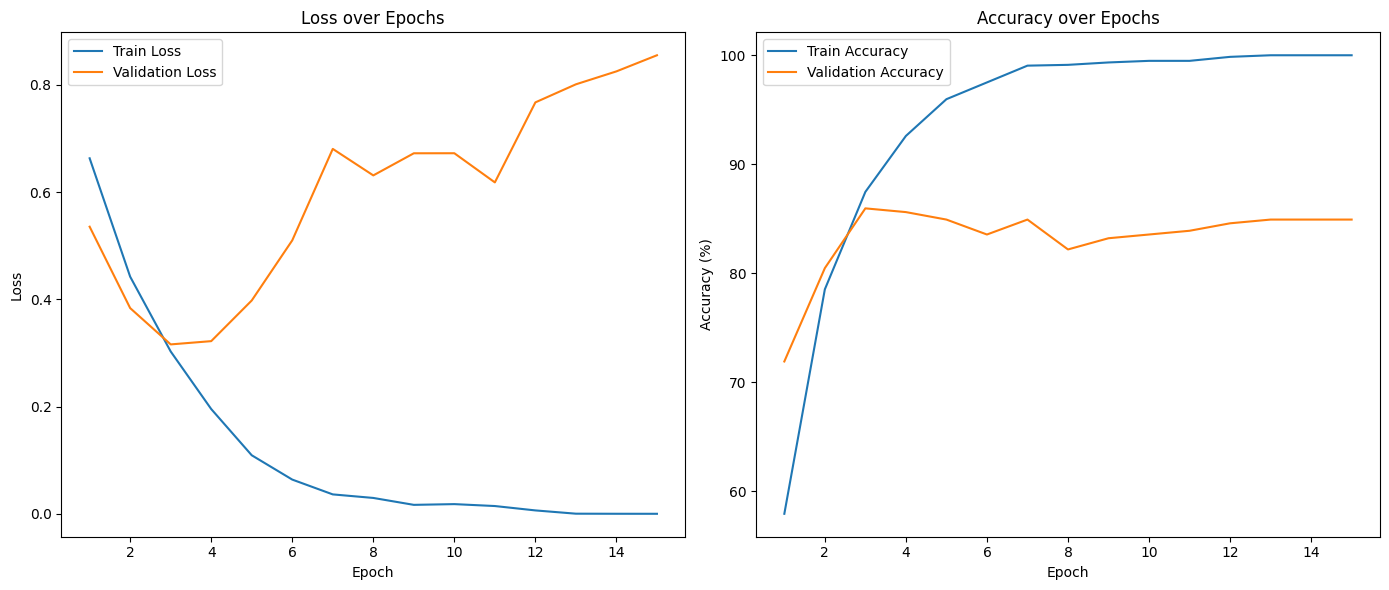

In [21]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, [acc * 100 for acc in train_accuracies], label='Train Accuracy')
plt.plot(epochs, [acc * 100 for acc in val_accuracies], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


/tmp/ipython-input-3316497872.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79d6981de980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1707, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79d6981de980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-pac

Accuracy: 0.8571, Precision: 0.8784, Recall: 0.8442, F1: 0.8609

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85       140
           1       0.88      0.84      0.86       154

    accuracy                           0.86       294
   macro avg       0.86      0.86      0.86       294
weighted avg       0.86      0.86      0.86       294



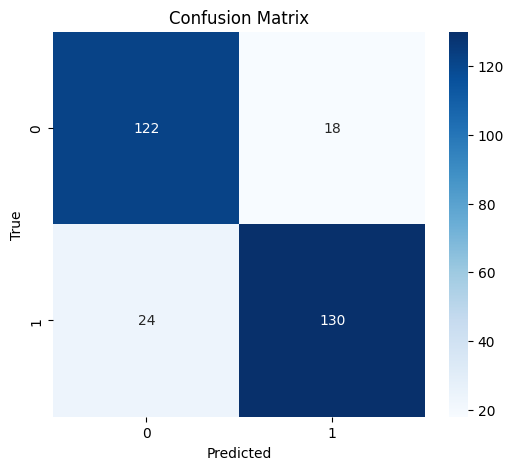

In [22]:
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for videos, labels in test_loader:
        videos, labels = videos.to(device), labels.to(device)
        with autocast():
            outputs = model(videos)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [23]:
!pip install decord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 66.5 MB/s eta 0:00:00


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from safetensors.torch import load_file
from decord import VideoReader, cpu
import numpy as np
import glob
import os

def load_my_model(model_path, device="cuda"):
    # 1. Инициализируем ТВОЮ архитектуру с теми же параметрами
    model = CNNGRU(num_classes=2, cnn_out_features=512, rnn_hidden_size=256, num_layers=2)

    # 2. Загружаем веса из safetensors
    weights = load_file(model_path)
    model.load_state_dict(weights)

    model = model.to(device).eval()
    return model

def predict_violence(video_path, model, transform, device="cuda"):
    # 1. Читаем видео (16 кадров)
    vr = VideoReader(video_path, ctx=cpu(0))
    indices = np.linspace(0, len(vr) - 1, 16, dtype=int)
    frames = vr.get_batch(indices).asnumpy() # [T, H, W, C]

    # 2. Подготовка тензора
    # Для твоей CNNGRU нужно: [Batch, Channels, Frames, Height, Width]
    # Сначала переставляем из [T, H, W, C] в [C, T, H, W]
    video_tensor = torch.from_numpy(frames).permute(3, 0, 1, 2).float() / 255.0

    # 3. Применяем нормализацию
    if transform:
        video_tensor = transform(video_tensor)

    # Добавляем Batch dimension: [1, 3, 16, 224, 224]
    video_tensor = video_tensor.unsqueeze(0).to(device)

    # 4. Инференс
    with torch.no_grad():
        with torch.amp.autocast('cuda'):
            outputs = model(video_tensor)
            probs = F.softmax(outputs, dim=1)
            confidence, prediction = torch.max(probs, 1)

    classes = ["Safe (Non-Violence)", "Violence Detected! ⚠️"]
    return classes[prediction.item()], confidence.item()

# --- ПРИМЕНЕНИЕ ---

# Ищем последний сохраненный файл модели
model_files = glob.glob("/content/*.safetensors")
test_videos = glob.glob(os.path.join("/content", "*.mp4"))

for model_path in model_files:
    model = load_my_model(model_path)
    print("============= MODEL =============")
    print(model_path)
    for test_video in test_videos:
        result, score = predict_violence(test_video, model, transform)

        print(f"Video path: {test_video}")
        print(f"Результат анализа: {result}")
        print(f"Уверенность модели: {score*100:.2f}%")
        print(f"\n\n")

============= MODEL =============
/content/model_acc_2.0.86.safetensors
Video path: /content/video_2026-02-23_15-21-00.mp4
Результат анализа: Safe (Non-Violence)
Уверенность модели: 83.16%



Video path: /content/video_2026-02-23_15-21-54.mp4
Результат анализа: Violence Detected! ⚠️
Уверенность модели: 69.54%



Video path: /content/video_2026-02-23_15-21-15.mp4
Результат анализа: Safe (Non-Violence)
Уверенность модели: 62.63%



Video path: /content/video_2026-02-23_15-20-42.mp4
Результат анализа: Violence Detected! ⚠️
Уверенность модели: 74.10%



Video path: /content/video_2026-02-23_15-21-08.mp4
Результат анализа: Safe (Non-Violence)
Уверенность модели: 98.61%



============= MODEL =============
/content/model_acc_1.0.86.safetensors
Video path: /content/video_2026-02-23_15-21-00.mp4
Результат анализа: Safe (Non-Violence)
Уверенность модели: 58.45%



Video path: /content/video_2026-02-23_15-21-54.mp4
Результат анализа: Violence Detected! ⚠️
Уверенность модели: 99.88%



Video path